In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append("../../../")

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier, XGBRFClassifier

from helpers.split import label_strings, tag_label_feature_split

/Users/rerobbins/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
def cross_gradient_boost_experiment(dataset):

    # load data and separate one hot encoded labels from features,
    # transform one hot encoded labels into label strings,
    # then encode label strings

    df = pd.read_pickle(dataset)
    _, one_hot_labels, X = tag_label_feature_split(df)
    labels = label_strings(one_hot_labels)

    le = LabelEncoder()
    y = le.fit_transform(pd.Series.ravel(labels))

    # divide into train and test data sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=10, stratify=y
    )

    # standardize features
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train)
    X_test_std = sc.transform(X_test)

    # calculate sample weights to deal with class imbalance
    sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
    model = XGBClassifier(
        use_label_encoder=False, objective="multi:softprob", eval_metric="mlogloss"
    )

    model.fit(X_train_std, y_train, sample_weight=sample_weights)

    predictions = model.predict(X_test_std)
    train_accuracy = model.score(X_train_std, y_train)
    test_accuracy = model.score(X_test_std, y_test)

    class_names = le.inverse_transform(list(model.classes_))
    print(f"Train: {train_accuracy = :f}\n")
    print(
        classification_report(
            y_train, model.predict(X_train_std), digits=4, target_names=class_names
        )
    )
    print(f"Test: {test_accuracy = :f}\n")
    print(
        classification_report(y_test, predictions, digits=4, target_names=class_names)
    )

    # generate confusion matrix and
    # display nicely with seaborn
    cm = confusion_matrix(y_test, predictions, normalize="true")
    heatmap_labels = list(le.classes_)
    plt.figure(figsize=(9, 9))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".3f",
        linewidths=0.5,
        square=True,
        cmap="Blues_r",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    name = os.path.basename(dataset).split(".")[0]
    plt.title(f"{name} test (row normalized)")

    return model

Train: train_accuracy = 0.886944

                 precision    recall  f1-score   support

    genre_blues     0.9280    1.0000    0.9627       374
genre_classical     0.9451    0.9337    0.9393      4221
  genre_country     0.9185    1.0000    0.9575       327
    genre_disco     0.8865    1.0000    0.9398       289
   genre_hiphop     0.8356    0.9559    0.8917      1701
     genre_jazz     0.7745    0.9799    0.8652      1241
    genre_metal     0.9288    1.0000    0.9631       665
      genre_pop     0.9168    0.7527    0.8267      4274
   genre_reggae     0.7839    0.9987    0.8783       788
     genre_rock     0.8789    0.8459    0.8621      3200

       accuracy                         0.8869     17080
      macro avg     0.8797    0.9467    0.9086     17080
   weighted avg     0.8924    0.8869    0.8855     17080

Test: test_accuracy = 0.523063

                 precision    recall  f1-score   support

    genre_blues     0.1429    0.0638    0.0882        94
genre_classical   

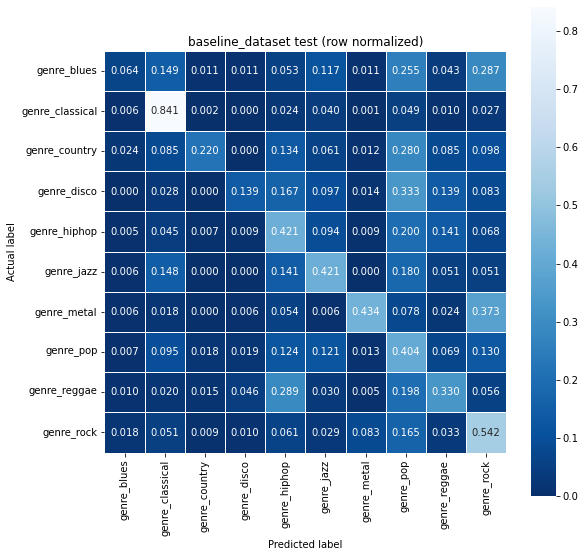

In [4]:
model_1 = cross_gradient_boost_experiment("../../../datasets/baseline_dataset.pickle")

Train: train_accuracy = 0.996136

                 precision    recall  f1-score   support

    genre_blues     0.9973    1.0000    0.9987       374
genre_classical     0.9979    0.9974    0.9976      4221
  genre_country     1.0000    1.0000    1.0000       327
    genre_disco     1.0000    1.0000    1.0000       289
   genre_hiphop     0.9959    1.0000    0.9979      1701
     genre_jazz     0.9952    0.9992    0.9972      1241
    genre_metal     1.0000    1.0000    1.0000       665
      genre_pop     0.9965    0.9890    0.9927      4274
   genre_reggae     0.9987    1.0000    0.9994       788
     genre_rock     0.9916    0.9978    0.9947      3200

       accuracy                         0.9961     17080
      macro avg     0.9973    0.9983    0.9978     17080
   weighted avg     0.9961    0.9961    0.9961     17080

Test: test_accuracy = 0.639195

                 precision    recall  f1-score   support

    genre_blues     0.4211    0.0851    0.1416        94
genre_classical   

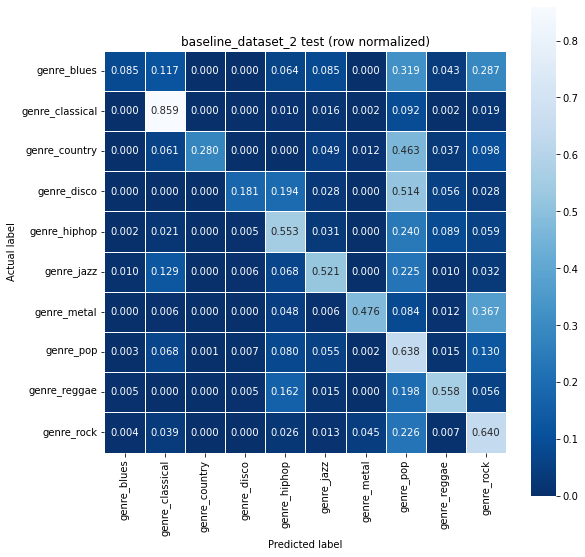

In [5]:
model_2 = cross_gradient_boost_experiment("../../../datasets/baseline_dataset_2.pickle")

Train: train_accuracy = 0.825234

                 precision    recall  f1-score   support

    genre_blues     0.7435    1.0000    0.8529       374
genre_classical     0.9398    0.9209    0.9302      4221
  genre_country     0.7047    1.0000    0.8268       327
    genre_disco     0.8006    1.0000    0.8892       289
   genre_hiphop     0.7538    0.8983    0.8197      1701
     genre_jazz     0.6973    0.9670    0.8103      1241
    genre_metal     0.8240    1.0000    0.9035       665
      genre_pop     0.8804    0.6270    0.7324      4274
   genre_reggae     0.6477    0.9987    0.7858       788
     genre_rock     0.8415    0.7369    0.7857      3200

       accuracy                         0.8252     17080
      macro avg     0.7833    0.9149    0.8337     17080
   weighted avg     0.8413    0.8252    0.8219     17080

Test: test_accuracy = 0.514165

                 precision    recall  f1-score   support

    genre_blues     0.0971    0.1064    0.1015        94
genre_classical   

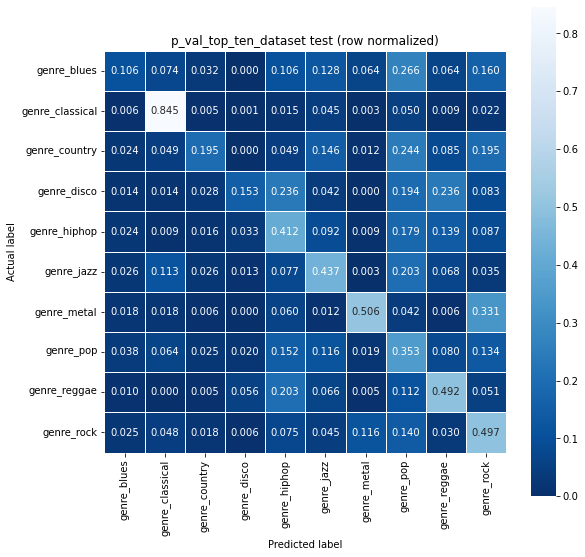

In [6]:
model_3 = cross_gradient_boost_experiment(
    "../../../datasets/p_val_top_ten_dataset.pickle"
)

Train: train_accuracy = 0.946604

                 precision    recall  f1-score   support

    genre_blues     0.9444    1.0000    0.9714       374
genre_classical     0.9814    0.9732    0.9773      4221
  genre_country     0.9675    1.0000    0.9835       327
    genre_disco     0.9863    1.0000    0.9931       289
   genre_hiphop     0.9078    0.9953    0.9495      1701
     genre_jazz     0.8797    0.9960    0.9342      1241
    genre_metal     0.9808    1.0000    0.9903       665
      genre_pop     0.9574    0.8671    0.9100      4274
   genre_reggae     0.9152    1.0000    0.9557       788
     genre_rock     0.9357    0.9319    0.9338      3200

       accuracy                         0.9466     17080
      macro avg     0.9456    0.9763    0.9599     17080
   weighted avg     0.9480    0.9466    0.9462     17080

Test: test_accuracy = 0.590026

                 precision    recall  f1-score   support

    genre_blues     0.1754    0.1064    0.1325        94
genre_classical   

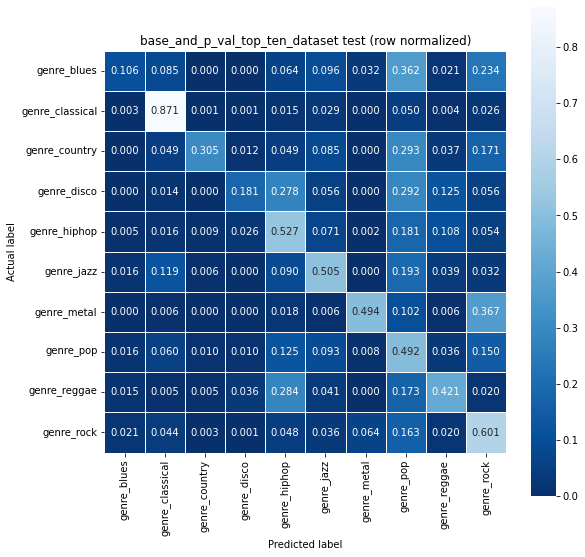

In [7]:
model_4 = cross_gradient_boost_experiment(
    "../../../datasets/base_and_p_val_top_ten_dataset.pickle"
)

Train: train_accuracy = 0.998244

                 precision    recall  f1-score   support

    genre_blues     1.0000    1.0000    1.0000       374
genre_classical     0.9995    1.0000    0.9998      4221
  genre_country     1.0000    1.0000    1.0000       327
    genre_disco     1.0000    1.0000    1.0000       289
   genre_hiphop     0.9977    1.0000    0.9988      1701
     genre_jazz     0.9992    1.0000    0.9996      1241
    genre_metal     1.0000    1.0000    1.0000       665
      genre_pop     0.9988    0.9942    0.9965      4274
   genre_reggae     1.0000    1.0000    1.0000       788
     genre_rock     0.9944    0.9984    0.9964      3200

       accuracy                         0.9982     17080
      macro avg     0.9990    0.9993    0.9991     17080
   weighted avg     0.9982    0.9982    0.9982     17080

Test: test_accuracy = 0.651370

                 precision    recall  f1-score   support

    genre_blues     0.3529    0.0638    0.1081        94
genre_classical   

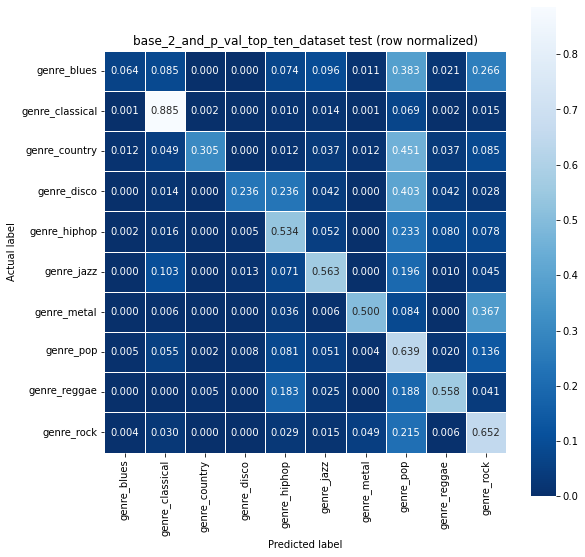

In [8]:
model_5 = cross_gradient_boost_experiment(
    "../../../datasets/base_2_and_p_val_top_ten_dataset.pickle"
)